<a href="https://colab.research.google.com/github/Laiba-Akhtar/Data_Science_and_Analytics_20sw057_task/blob/main/20SW057_Analyze_ab_test_results_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Resources](#Resources)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [21]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [22]:
# read data
df = pd.read_csv('/content/ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [23]:
# check rows with shape method
df.shape

(294478, 5)

In [24]:
# info helps to get an overview as well
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [25]:
# use unique method
users_unique = df.user_id.nunique()
users_unique

290584

d. The proportion of users converted.

In [26]:
# proportions of user who converted (i.e. converted = 1)
df[df.converted == 1].user_id.count()/df.shape[0]

# alternatively
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [27]:
# there are two dimentions to this
# 1. get the number where landing_page equals new_page but group is not treatment
# 2. get the number where landing_page not new_page but group is treatment
# adding these two will give total misalignment
df[(df.landing_page == 'new_page') & (df.group != 'treatment')].user_id.count() + df[(df.landing_page != 'new_page') & (df.group == 'treatment')].user_id.count()

3893

f. Do any of the rows have missing values?

In [28]:
# we find the rows with missing values with isnull
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [29]:
# using the same logic from e.
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | ((df.landing_page != 'new_page') & (df.group == 'treatment'))].index)

In [30]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [31]:
# check for info
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [32]:
df2.user_id.nunique()

290584

`df.info()` shows 290585 entries but `df2.user_id.nunique()` gives 290584. Meaning there is one duplicate.

b. There is one **user_id** repeated in **df2**.  What is it?

In [33]:
# here we look for duplicated user_id, but we show both of those in our result by keep=False
df2.user_id[df2.user_id.duplicated(keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**?

In [34]:
# at what index duplicated user_id is
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [35]:
# we can remove duplicates in multiple ways
# removing by index, removing by first or last entry as well as by unique column timestamp
df2 = df2[df2.timestamp != '2017-01-09 05:37:58.781806']

In [36]:
# quick sanity check
df2.user_id.nunique()

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [39]:
df2.converted.mean()

# alternatively
df2.describe().loc['mean'].converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [40]:
# logic: query the converted column where group column value is control and take mean
df2.converted[df2.group == 'control'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [41]:
# same logic as above, here we do it for treatment instead of control
df2.converted[df2.group == 'treatment'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [42]:
df2[df2.landing_page == 'new_page'].count()/df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.


- **Given the probability that an individual received the new page is 0.50006, suggests that there is an equal chance that an individual received the old page at the same time. **
- **Besides, the probability of conversion from control group and treatment group is almost similar. Just different at 3rd decimal point.**
- **Within such circumstances we can not confidently say that one page leads to more conversions. In fact, it is quite the opposite.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null Hypothesis: ** The probability of old page better than new page is greater or equal to probability of new page.

**Alternative Hypothesis: ** The probability of new page being better than new page is less than that of a new page.

$$ H_{0} : p_{old} - p_{new} \geq 0$$
$$ H_{A} : p_{old} - p_{new} < 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null?

In [43]:
# convert rate is how many users converted (i.e. converted = 1)
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [44]:
p_old = df2.converted.mean() # the same!!!
p_old

0.11959708724499628

c. What is $n_{new}$?

In [45]:
# number of users who got the new page (i.e. group = treatment)
n_new = df2[df2.group == 'treatment'].count()[0]
n_new

145310

d. What is $n_{old}$?

In [46]:
# number of users who reamined with old page (i.e. group = control)
n_old = df2[df2.group == 'control'].count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

**NOTE: **
> - Below few cells will see alternative method, please run both of those in two different runs. They both give different results! <br>
> - As a matter of fact they **should not.** <br>
> - The difference will be visible in the histogram and in p-value

In [82]:
# simulating n_new transaction that have probabiliy of receiving new page, using binomial gives the outout as the number of 1's
new_page_converted = np.random.binomial(1,p_new,n_new)
new_page_converted.mean()

0.11864978322207693

In [88]:
# alternatively
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
new_converted_simulation.mean()

0.11864114169706144

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [89]:
# simulating n_new transaction that have probabiliy of having old page, using binomial gives the outout as the number of 1's
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.11879620579043738

In [90]:
# alternatively
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
old_converted_simulation.mean()

0.11846829852554483

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [93]:
# probabilty of new and old page based upon simulated values in e. and f.
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
p_new - p_old

-0.0001464225683604492

In [94]:
# alternatively
new_converted_simulation.mean() - old_converted_simulation.mean()

0.00017284317151661233

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [95]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)  # bootstrapping
    old_page_converted = np.random.binomial(1,p_old,n_old) # bootstrapping
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [96]:
# alternatively
p_diffs_alt = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

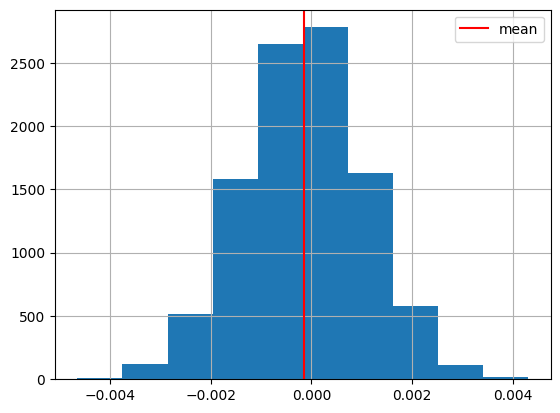

In [97]:
# convert p_diffs to numpy array for array based computations in the future
p_diffs = np.array(p_diffs)

# histogram
plt.hist(p_diffs)
plt.grid()
plt.axvline(p_diffs.mean(), color='r', label='mean')
plt.legend();

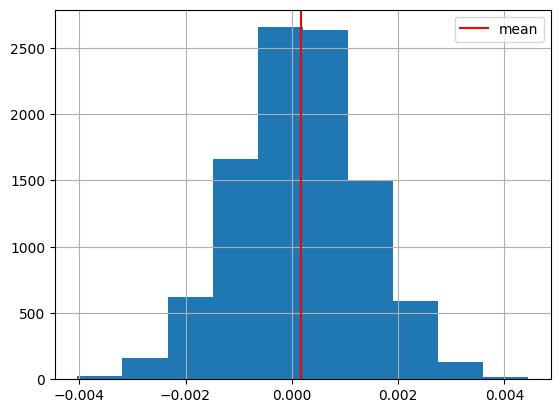

In [98]:
# alternatively
# histogram
plt.hist(p_diffs_alt)
plt.grid()
plt.axvline(p_diffs_alt.mean(), color='r', label='mean')
plt.legend();

As expected the mean is very close to 0.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [99]:
actual_diff = df2.converted[df2.group == 'treatment'].mean() - df2.converted[df2.group == 'control'].mean()
(actual_diff < p_diffs).mean()

0.8848

In [100]:
# alternatively
actual_diff = df2.converted[df2.group == 'treatment'].mean() - df2.converted[df2.group == 'control'].mean()
(actual_diff < p_diffs_alt).mean()

0.9307

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- **What we computed in part j. is called p-value in scientific studies.**
- **p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**
- **In our case the p-value is so big that we can confidently say that we fail to reject null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [101]:
# quick check before diving in
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [102]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].converted.count()
n_new = df2[df2.group == 'treatment'].converted.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

From the link, we have all the values required. However, it is worth noticing that the argument alternative in the function is 'two-sided' by default. But our hypothesis is not designed around 'either-or' scenario at this point. Therefore, the argument alternative will be 'smaller', meaning one-tailed experiment. For further reading please refer to [wikipedia](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests)  article. As well as, a great informative [video](https://www.youtube.com/watch?v=fXOS4Q3nJQY) about z-scores.

In [103]:
# based upon the documentation
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- **A z-score represents how many standard deviations away our data point is from the mean**
- **A positive z-score suggests that our data point is on the right side of the mean line on the bell curve**
- **p-value of 0.9050 is very close to the p-value we computed earlier in part j.**
- **With this computation, we can confidently say we fail to reject null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**This is a case of Logistic Regression. In this scenario, we want to predict something that has only two possible outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [104]:
# quick consistency check
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [105]:
# copy the dataframe to a new one, for clarity
df2_copy = df2.copy()

In [106]:
# another sanity check, if True, go ahead
df2_copy.shape == df2.shape

True

In [107]:
# add an intercept
df2_copy['intercept'] = 1

# using pd.get_dummies to convert the 'landing_page' and 'group' to 1s and 0s
df2_copy[['landing_page_new', 'landing_page_old']] = pd.get_dummies(df2_copy['landing_page'])
df2_copy[['ab_page_control','ab_page_treatment']] = pd.get_dummies(df2_copy['group'])

In [108]:
# here, we will use landing_page_old and ab_page_control as our baselines, therefore remove those
df2_copy.drop(['landing_page_old','ab_page_control'], axis=1, inplace=True)

In [109]:
df2_copy.head()

,user_id,timestamp,group,landing_page,converted,intercept,landing_page_new,ab_page_treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [110]:
logit_mod = sm.Logit(df2_copy['converted'], df2_copy[['intercept', 'ab_page_treatment']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [111]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:               8.077e-06
Time:                        18:02:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page_treatment    -0.0150      0.011     -1.311      0.190      -0.037       0.007
=====================================================================================
"""

In [112]:
# interprete the coefficients
1/np.exp(results.params[1])

1.0151020136964732

In [113]:
# additional: question posed by previous reviewer
# how to get p-value as if it were a one-tailed test
1-0.190/2

0.905

- For each 1 unit decrease in `ab_page_treatment`, conversion is 1.015 time likely holding all the other variables constant. Which is not really why we would launch a new_page!

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

- **As we already built the base for z-score and p-value in part-m, this p-value is different of course.**
- **The logistic regression is two-tailed case. We are exploring only two possible outcomes and it can go either way.**
- **Interesting part to observe is z-score, absolute of which confirms the number in part-m.**

The null and alternative hypothesis associated with regression model will be as following:
$$ H_{0}: p_{old} - p_{new} = 0$$
$$ H_{0}: p_{old} - p_{new} \neq 0$$

In [114]:
# duration of the experiment
duration = np.array(pd.to_datetime(df.timestamp).sort_values(ascending=True))
td = duration[-1] - duration[0]
days = td.astype('timedelta64[D]')
days / np.timedelta64(1, 'D')

21.0

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There can be many other factors that can be taken into consideration to add into our regression model.**
- **One of the first to consider would be the duration. The duration of this experiment was 21 days. Too short, it would be advisable to increase the duration**
- **Geographic location is another important factor. If the page is available in multiple languages, for example, it can diversify the sample**
- **Parameters like click through rate is another factor to consider**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables.

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [116]:
# read file and join the dfs
countries_df = pd.read_csv('/content/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [117]:
# quick check
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [118]:
# Create the necessary dummy variables
df_new[['canada','uk','us']] = pd.get_dummies(df_new['country'])

In [119]:
# let's consider US being our baseline, therefore, we drop US
df_new.drop(['us'], axis=1, inplace=True)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [120]:
df_new.head()

,country,timestamp,group,landing_page,converted,canada,uk
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1


In [121]:
# fitting linear model
df_new['intercept'] = 1

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','canada','uk']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [122]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:               1.521e-05
Time:                        18:03:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
canada        -0.0408      0.027     -1.518      0.129      -0.093       0.012
uk             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [123]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

Above results can be read as:
- users from uk are 1.009 times more likely to convert as compared to users from us
- users from canada are 1.042 times more likely to less convert as compared to users from us

<a id='conclusions'></a>
## Conclusions

Within the framework this project, we tried to understand whether the company should implement a new page or keep the old page with following:
- Probability based approach
- A/B test
- Regression approach

**Probability based approach:**
  - We found that probability of an individual receiving the new page is 0.5001
  - Meaning, there is almost the same chance that an individual received the old page

**A/B test:**
  - In A/B test we set up our hypothesis to test if new page results in better conversion or not
  - We simulated our user groups with respect to conversions
  - We found the p_value to be 0.8879
  - With such a p-value, we failed to reject null hypothesis
  - By using the built-in `stats.proportions_ztest` we computed z-score and p-value which confirmed our earlier p-value and failure to reject null hypothesis
  
**Regression Approach:**
  - We looked at exploring two possible outcomes. Whether new page is better or not.
  - With logistic regression results, we again encountered same z-score as well as p-value of 0.190, corresponding two-tailed case
  - By further adding geographic location of the users, we tried to find if any specific country had an impact on conversion
  - The result gave a similar outlook and suggested that the countries have no impact on the conversion rate.
  
**Consideration:**
  - We also looked at the duration of the experiment (21 days).
  - This is a relatively short period of time to run the A/B test.
  - Due to Change aversion effect, a group of users may give an unfair advantage to the older page
  - Similarly, due to Novelty effect, users may give an unfair advantage to the newer page

<a id='Resources'></a>
## Resources
- Numpy timedelta conversion to days: https://stackoverflow.com/questions/18215317/extracting-days-from-a-numpy-timedelta64-value
- How to calculate z scores used in statistics class: https://www.youtube.com/watch?v=fXOS4Q3nJQY
- Copy pandas dataframe: https://stackoverflow.com/questions/45600342/copy-pandas-dataframe-using-trick
- One and two tailed tests: https://en.wikipedia.org/wiki/One-_and_two-tailed_tests
- How to correctly interprete p-values: http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-correctly-interpret-p-values